<center> <img src = img.png alt="drawing" style="width:400px;">

In [359]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import f_classif
import category_encoders as ce
import re
import nums_from_string
import geopy.distance

# инструменты для лингвистического анализа:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textblob
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer

# инструменты для визуализации:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# параметры отображения содержимого на экране:
from IPython.display import display
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)

# инструменты для построения модели:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [360]:
# функция для бинарного кодирования признака:


In [361]:
hotels = pd.read_csv('hotels_train.csv')

# 0. Исходные данные:

In [362]:
display(hotels.head())
display(hotels.info())
print(f'\nСтолбцы с явными пропусками данных:\n{hotels.isnull().sum()[hotels.isnull().sum() > 0]}')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.508,-0.144
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521,-0.123
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845,2.326
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,11,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,48.889,2.395
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,20,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,52.386,4.847


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None


Столбцы с явными пропусками данных:
lat    2448
lng    2448
dtype: int64


#### Первоначальная версия датасета содержит 17 полей со следующей информацией:

hotel_address — адрес отеля;
review_date — дата, когда рецензент разместил соответствующий отзыв;
average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
hotel_name — название отеля;
reviewer_nationality — страна рецензента;
negative_review — отрицательный отзыв, который рецензент дал отелю;
review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
positive_review — положительный отзыв, который рецензент дал отелю;
review_total_positive_word_counts — общее количество слов в положительном отзыве;
reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
total_number_of_reviews — общее количество действительных отзывов об отеле;
tags — теги, которые рецензент дал отелю;
days_since_review — количество дней между датой проверки и датой очистки;
additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
lat — географическая широта отеля;
lng — географическая долгота отеля.

* ## Целевой признак (reviewer_score)
**Оценим распределение величины**

In [363]:
# проведем тест на нормальность:
alpha = 0.05
_, p = stats.normaltest(hotels['reviewer_score'])

print('Для распределения оценок туристов: p=%.4f' % p)
print('Данные распределены нормально.') if p > alpha/2 else print('Данные не распределены нормально.')

Для распределения оценок туристов: p=0.0000
Данные не распределены нормально.


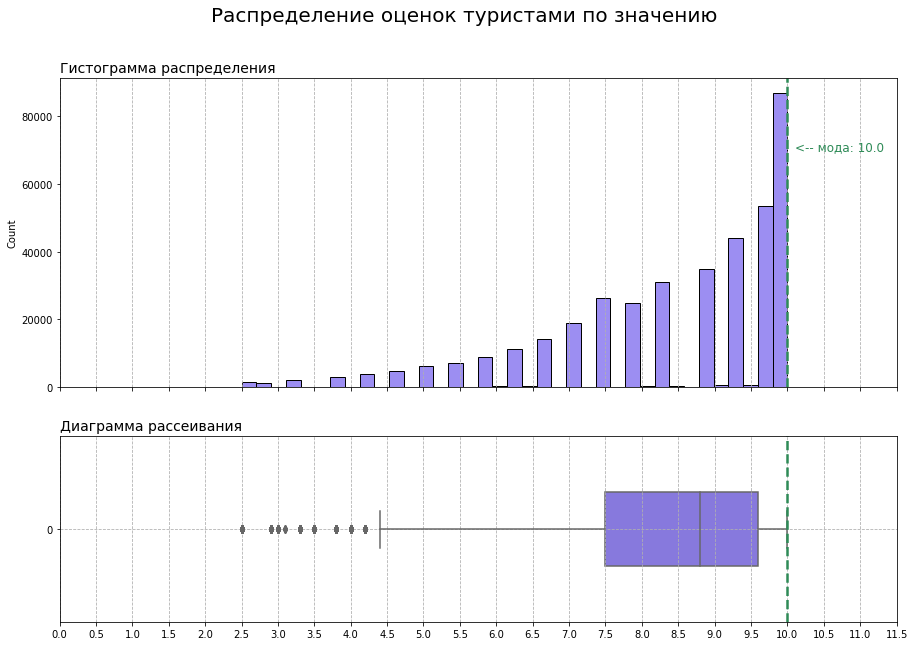

In [364]:
# подготовим данные для диаграмм:
data_score = hotels['reviewer_score']
mode_score = (hotels['reviewer_score'].mode()).max()
colors_score = ['mediumslateblue', 'seagreen']

# формируем размеры диаграмм:
fig1, ax1 = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(15, 10), gridspec_kw={'height_ratios': [5, 3]})
plt.suptitle('Распределение оценок туристами по значению', size=20)

# строим гистограмму распределения:
ax1[0].set_title('Гистограмма распределения', ha='left', x=.0, fontsize=14)
sns.histplot(ax=ax1[0], data=data_score, bins=len(hotels['reviewer_score'].value_counts()), color=colors_score[0]).xaxis.grid(linestyle='--')

# строим коробчатую диаграмму:
ax1[1].set_title('Диаграмма рассеивания', ha='left', x=.0, fontsize=14)
sns.boxplot(ax=ax1[1], data=data_score, color=colors_score[0], width=0.4, orient='h').grid(linestyle='--')

# для наглядности добавим линию модального значения:
ax1[0].axvline(x=mode_score, color=colors_score[1], ls='--', lw=2.5)
ax1[0].text(10.1, 70000, f'<-- мода: {mode_score}', fontsize = 12, color=colors_score[1])
ax1[1].axvline(x=mode_score, color=colors_score[1], ls='--', lw=2.5)

ax1[1].set_xticks(np.arange(0, 12, 0.5))
ax1[1].set_xlabel('');

##### И тест и график показывают, что данные не распределены нормально. В уровне количества выставленных оценок - шаг от шага наблюдаются "взлеты и падения" показателей. При поступательном движении по шкале оценок - некоторые оценки более популярны, некоторые - почти не заметны, некоторые - отсутствуют вовсе.
##### Это связано со спецификой расчета и округления средней оценки отзыва на Booking.com на основании оценок по отдельным категориям. Некоторые категории оценки, например 9.8 или 7.2 - не встречаются совсем. Этот средний балл невозможно получить ни при какой комбинации оценок по различным параметрам.
##### Однако очертания одностороннего нормального распределения есть. Множество значений оценок с примерным шагом 0.4 демонстрирует картину именно такого распределения.

In [365]:
# это демонстрирует и таблица уникальных значений:
hotels['reviewer_score'].value_counts()

10.000    86803
9.600     53502
9.200     44053
8.800     34795
8.300     30903
7.500     26164
7.900     24901
7.100     18529
6.700     14117
6.300     11244
5.800      8962
5.400      7082
5.000      6278
4.600      4660
4.200      3827
3.800      3017
3.300      2063
2.500      1632
2.900      1211
9.500       523
9.000       483
8.000       388
8.500       379
7.000       293
6.500       274
6.000       184
5.500       161
4.500        97
4.000        66
3.500        61
9.400        47
8.100        28
3.000        25
6.900        23
5.600        13
4.400         9
3.100         6
Name: reviewer_score, dtype: int64

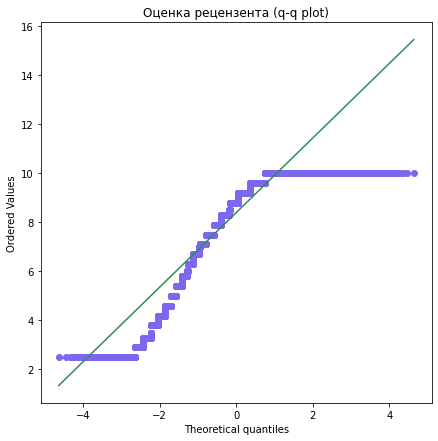

In [366]:
# и диаграмма теоретических квартилей:
fig0, ax0 = plt.subplots(figsize=(7, 7))

stats.probplot(hotels['reviewer_score'], plot=ax0)
ax0.set_title('Оценка рецензента (q-q plot)')
ax0.get_lines()[0].set_color('mediumslateblue')
ax0.get_lines()[0].set_markerfacecolor('mediumslateblue')
ax0.get_lines()[1].set_color('seagreen')

plt.show()

# 1. Исследование и проектирование признаков (FEATURE ENGINEERING):

Целью данного раздела будем считать максимальную адаптацию данных

## 1.1 ХАРКЕТИРСТИКИ ОТЕЛЯ
***Название и Адрес отеля ('hotel_address', 'hotel_name')***
***Координаты отеля - Географическая широта и долгота отеля ('lat', 'lng')***
***Средний балл отеля за последний год ('average_score')***
***Общее количество отзывов об отеле ('total_number_of_reviews')***
***Общее количество оценок без отзывов ('additional_number_of_scoring')***

Исследуем данные о названии и адресе отеля на наличие пропуском и дубликатов:

In [367]:
hotels[['hotel_address', 'hotel_name']].describe()

,hotel_address,hotel_name
count,386803,386803
unique,1493,1492
top,163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom,Britannia International Hotel Canary Wharf
freq,3587,3587


In [368]:
print('Дублирование Адреса отеля:')
pivot_a = hotels[['hotel_address', 'hotel_name']].groupby(by='hotel_address').nunique()
address_rep = pivot_a[pivot_a['hotel_name'] != 1].index.to_list()
names_rep = hotels[hotels['hotel_address'].isin(address_rep)][['hotel_name', 'hotel_address']].value_counts()

display(names_rep)

print('Дублирование Названия отеля:')

pivot_n = hotels[['hotel_address', 'hotel_name']].groupby(by='hotel_name').nunique()
name_rep = pivot_n[pivot_n['hotel_address'] != 1].index.to_list()
addresses_rep = hotels[hotels['hotel_name'].isin(name_rep)][['hotel_name', 'hotel_address']].value_counts()

display(addresses_rep)

Дублирование Адреса отеля:


hotel_name                            hotel_address                                                             
Club Quarters Hotel Trafalgar Square  8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom    716
The Grand at Trafalgar Square         8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom    541
dtype: int64

Дублирование Названия отеля:


hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    440
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           222
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     47
dtype: int64

***Дублирование адреса - это два разных отеля в одном здании. А вот одинаковые названия - это один и тот же отель в разных городах. Пометим его названием города:***

In [369]:
hotels['hotel_name'] = hotels.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in name_rep)
    else row['hotel_name'], axis=1)

display(hotels[hotels['hotel_name'].str.contains(name_rep[0])]['hotel_name'].value_counts())

Hotel Regina Barcelona    440
Hotel Regina Vienna       222
Hotel Regina Milan         47
Name: hotel_name, dtype: int64

* ### НАЗВАНИЕ ОТЕЛЯ ('hotel_name')

***Так как название - это строка, то необходимо его кодировать. Код названия сам по себе вряд ли может что-то сообщить модели. Отелей больше тысячи и числовой код скорее запутает модель, ведь размерность цифры кода не несет никакой смысловой нагрузки.***

***Попробуем сообщить модели хоть какую-то осмысленную информацию. Название - это уникальная характеристика отеля. Отели можно отсортировать, например, по популярности (кол-во отзывов) или по рейтингу (средний бал).***

In [370]:
hotels_names = hotels['hotel_name'].value_counts(ascending=False)[:300]
hotels['hotel_cat'] = hotels['hotel_name'].apply(lambda n: n if n in hotels_names.index else 'other')

# применим порядковое кодирование:
ord_encoder = ce.OrdinalEncoder()
hotels['hotel_cat'] = hotels['hotel_cat'].astype('category')
hotels_bin = ord_encoder.fit_transform(hotels['hotel_cat'])
hotels = pd.concat([hotels, hotels_bin], axis=1)

In [371]:
col = hotels.columns.tolist()
col[18] = 'hotel_code'

hotels.set_axis(col, axis=1, inplace=True)
hotels.drop('hotel_cat', axis=1);

* ### АДРЕС ОТЕЛЯ ('hotel_address')

In [372]:
addresses = pd.Series(hotels['hotel_address'].unique())
display(addresses)

0       Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
1                   130 134 Southampton Row Camden London WC1B 5AF United Kingdom
2                                151 bis Rue de Rennes 6th arr 75006 Paris France
3                              216 Avenue Jean Jaures 19th arr 75019 Paris France
4                                       Molenwerf 1 1014 AG Amsterdam Netherlands
                                          ...                                    
1488                              Viriotgasse 5 09 Alsergrund 1090 Vienna Austria
1489                                     8 rue d Anjou 8th arr 75008 Paris France
1490        Prinsengracht 717 Amsterdam City Center 1017 JW Amsterdam Netherlands
1491                          43 Rue De l Abb Gr goire 6th arr 75006 Paris France
1492                      Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria
Length: 1493, dtype: object

***Из адреса можно извлечь гораздо больше полезной информации, чем из названия.***
***Страна, город и индекс как характеристика района могут стать дополнительными признаками!***

#### Новый признак: СТРАНА И/ИЛИ ГОРОД ОТЕЛЯ ('hotel_country' / 'hotel_city')

In [373]:
# для вычленения гео параметров можно было бы воспользоваться locationtagger, но он работает довольно медленно и с ошибками
# если нужен абсолютно воспроизводимы код - то можно немного пренебречь качеством обработки и использовать универсальный код
# но мы пойдем другим путем :D

# поскольку у нас не большое количество уникальных стран и городов в данных - воспользуемся простой обработкой текста:
countries = addresses.apply(lambda x: x.split()[-1])
countries = countries.apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
countries.value_counts()

France            458
United Kingdom    399
Spain             211
Italy             162
Austria           158
Netherlands       105
dtype: int64

In [374]:
cities = addresses.apply(lambda x: x.split()[-2])
cities = cities.apply(lambda x: 'London' if x == 'United' else x)
cities.value_counts()

Paris        458
London       399
Barcelona    211
Milan        162
Vienna       158
Amsterdam    105
dtype: int64

***В каждой стране отели выбраны только из одного города, поэтому можно добавить только что-то одно, например, признак страны:***

In [375]:
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

***Кодируем информацию о стране:***

In [376]:
hotels['hotel_country'] = hotels['hotel_country'].astype('category')
hotels['hotel_country_code'] = hotels['hotel_country'].cat.codes
hotels[['hotel_country', 'hotel_country_code']][:10]

,hotel_country,hotel_country_code
0,United Kingdom,5
1,United Kingdom,5
2,France,1
3,France,1
4,Netherlands,3
5,Italy,2
6,United Kingdom,5
7,Austria,0
8,United Kingdom,5
9,United Kingdom,5


#### Новый признак: РАЙОН ОТЕЛЯ ('hotel_district')

***Расположение отеля в городе, удаленность от центра способны сильно повлиять на впечатление туриста об отеле. Среди прочих параметров все туристы, оставляющие отзыв на Booking.com обязательно оценивают месторасположение.***

Идентифицировать район города можно по индексу в строке адреса отеля.

In [377]:
# добавим почтовый индекс отеля как идентификатор района:
def get_postcode(address):
    address_list = address.split()
    postcode_place = {'Kingdom': -4, 'Spain': -3, 'France': -3, 'Austria': -3, 'Netherlands': -4, 'Italy': -3}
    postcode = str(address_list[postcode_place[address_list[-1]]])
    return postcode[:-1] if (address_list[-1] == 'Kingdom' and postcode[-1].isalpha()) else postcode

hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_postcode)

# из файла с данными об расположении центральных районов данных городов - определим категорию района:
districts = pd.read_excel('regions.xlsx', sheet_name='postcodes')
districts['PostCode'] = districts['PostCode'].apply(lambda x: str(x))
districts = districts.set_index('PostCode')
districts = districts.to_dict()
districts = districts['Type of District']

hotels['district_type'] = hotels['hotel_postcode'].apply(lambda c: districts[c])

#### <span style="color:green">Визуализируем соотношение средних значений целевой переменной в зависимости от района расположения отеля:</span>

In [378]:
# посмотрим, отличаются ли средние оценки отелей, в зависимости от района расположения:
pivot_adr = pd.pivot_table(hotels,
                           index=['hotel_country', 'district_type', 'hotel_postcode'],
                           values='average_score',
                           aggfunc='mean')

pivot_adr = pivot_adr.reindex(pivot_adr['average_score'].sort_values(ascending=False).index)

pivot_adr[:20]

average_score
hotel_country  district_type  hotel_postcode               
Netherlands    Center         1015                    9.368
               Other          1067                    9.300
               Center         1016                    9.242
United Kingdom Center         SE11                    9.200
Austria        Center         1015                    9.152
United Kingdom History Center EC2                     9.101
Netherlands    Other          1097                    9.100
United Kingdom Other          E15                     9.000
               History Center EC1                     8.912
Netherlands    Center         1018                    8.878
Spain          Center         08010                   8.869
United Kingdom Other          E20                     8.862
               Center         SE10                    8.860
Spain          Center         08037                   8.832
                              08008                   8.810
France         Center         75007                   8.801
Netherlands    Center         1053                    8.800
                              1052                    8.800
United Kingdom Other          W13                     8.800
Spain          History Center 08002                   8.768

***Кодируем информацию о районе и его типе по индексу:***

In [379]:
# кодируем информацию о типе района:
def get_district_code(district_type, country_code):
    country_code += 1
    if district_type == 'History Center':
        return country_code * 3
    elif district_type == 'Center':
        return country_code * 2
    elif district_type == 'Other':
        return country_code
    else:
        return 0

hotels['district_code'] = hotels.apply(lambda row: get_district_code(row['district_type'], row['hotel_country_code']), axis=1)

# присвоим каждому району категорию в зависимости от популярности отелей в данной местности у туристов
# для этого нормализуем информацию о среднем рейтинге отеля в зависимости от индекса
pivot_adr = pd.pivot_table(hotels, index='hotel_postcode', values='average_score', aggfunc='mean')
pivot_adr = pivot_adr.reindex(pivot_adr['average_score'].sort_values(ascending=False).index)

mm_scaler = preprocessing.MinMaxScaler()
x_data = pivot_adr.values
x_scaled = mm_scaler.fit_transform(x_data)
pivot_adr['district_rating'] = x_scaled

hotels['district_rating'] = hotels['hotel_postcode'].apply(lambda x: pivot_adr['district_rating'][x])

hotels[['hotel_address', 'hotel_postcode', 'district_rating']][:10]

,hotel_address,hotel_postcode,district_rating
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,W1,0.546
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,WC1,0.494
2,151 bis Rue de Rennes 6th arr 75006 Paris France,75006,0.748
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,75019,0.255
4,Molenwerf 1 1014 AG Amsterdam Netherlands,1014,0.647
5,Via Mecenate 121 20138 Milan Italy,20138,0.434
6,97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom,SW7,0.495
7,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria,1080,0.643
8,190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom,SW7,0.495
9,Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom,W11,0.374


* ### ГЕОГРАФИЧЕСКИЕ КООРДИНАТЫ ОТЕЛЯ ('lat', 'lng')

Посмотрим на список отелей, у которых отсутствуют координаты:

In [380]:
hotels[hotels.isnull().any(1)]['hotel_name'].value_counts()

Fleming s Selection Hotel Wien City                 496
Hotel City Central                                  421
Hotel Atlanta                                       285
Maison Albar Hotel Paris Op ra Diamond              224
Hotel Daniel Vienna                                 182
Hotel Pension Baron am Schottentor                  172
Austria Trend Hotel Schloss Wilhelminenberg Wien    141
NH Collection Barcelona Podium                      113
Derag Livinghotel Kaiser Franz Joseph Vienna        112
City Hotel Deutschmeister                            63
Holiday Inn Paris Montmartre                         47
Hotel Park Villa                                     44
Cordial Theaterhotel Wien                            40
Roomz Vienna                                         34
Mercure Paris Gare Montparnasse                      28
Hotel Advance                                        26
Renaissance Barcelona Hotel                          20
Name: hotel_name, dtype: int64

In [381]:
# проверим, есть ли у этих отелей вообще координаты в базе:
hotels_without_coor = list(hotels[hotels.isnull().any(1)]['hotel_name'].value_counts().index)
hotels[hotels['hotel_name'].isin(hotels_without_coor)][['lat', 'lng']].value_counts()

Series([], dtype: int64)

Получается, что в базе есть 17 отелей с пропущенными координатами. Можно заполнить х средними значениями района, в котором расположен отель(используя индекс):

In [382]:
# вычисляем средние значения координат для каждого района:
pivot_coor = pd.pivot_table(hotels,
                           index='hotel_postcode',
                           values=['lat', 'lng'],
                           dropna=True,
                           aggfunc='mean')
pivot_coor

,lat,lng
hotel_postcode,,
08001,41.380,2.171
08002,41.384,2.173
08003,41.386,2.179
08004,41.373,2.156
08005,41.394,2.199
...,...,...
W6,51.492,-0.226
W8,51.500,-0.191
W9,51.524,-0.185


In [383]:
hotels['lat'] = hotels.apply(lambda row: pivot_coor['lat'][row['hotel_postcode']] if np.isnan(row['lat']) else row['lat'], axis=1)
hotels['lng'] = hotels.apply(lambda row: pivot_coor['lng'][row['hotel_postcode']] if np.isnan(row['lng']) else row['lng'], axis=1)

print(f'\nСтолбцы с явными пропусками данных теперь отсутствуют:\n{hotels.isnull().sum()[hotels.isnull().sum() > 0]}')


Столбцы с явными пропусками данных теперь отсутствуют:
Series([], dtype: int64)


***Из координат отеля можно выудить еще один признак, который может влиять на оценку постояльца отеля - удаленность отеля от центра города:***

#### Новый признак: РАССТОЯНИЕ ДО ЦЕНТРА ГОРОДА ('hotel_distance_to_center'):

In [384]:
# Нам нужны координаты центра каждого города:
# (с сайта: https://dateandtime.info/)
centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')

display(centers)

,city,center_lat,center_lng
country,,,
United Kingdom,London,51.509,-0.126
France,Paris,48.853,2.349
Spain,Barcelona,41.389,2.159
Italy,Milan,45.464,9.190
Austria,Vienna,48.208,16.372
Netherlands,Amsterdam,52.374,4.890


In [385]:
def get_to_center_distance(country, lng, lat):
    center_lat = centers['center_lat'][country]
    center_lng = centers['center_lng'][country]

    return geopy.distance.geodesic([center_lng, center_lat], [lng, lat]).km

# можно одной строкой кода вычислять координаты для каждой строки DataFrame, но geopy.distance.geodesic функция довольно медленная
# hotels['hotel_distance_to_center'] = hotels.apply(lambda row: get_to_center_distance(row['hotel_country'], row['lng'], row['lat']), axis=1)

# чтобы не обрабатывать 500 тыс. строк посчитаем эту характеристику для каждого отеля и потом сопоставить полученные результаты:
hotels_unique = hotels[['hotel_name', 'hotel_country', 'lng', 'lat']].drop_duplicates()
hotels_unique['hotel_distance_to_center'] = hotels_unique.apply(lambda row: get_to_center_distance(row['hotel_country'], row['lng'], row['lat']), axis=1)
hotels_unique.drop(['hotel_country', 'lng', 'lat'], axis=1, inplace=True)

hotels = hotels.merge(hotels_unique, how='left', on='hotel_name', sort=False)

hotels[['hotel_name', 'hotel_distance_to_center']]

,hotel_name,hotel_distance_to_center
0,The May Fair Hotel,1.984
1,Mercure London Bloomsbury Hotel,1.420
2,Legend Saint Germain by Elegancia,2.712
3,Mercure Paris 19 Philharmonie La Villette,6.402
4,Golden Tulip Amsterdam West,4.886
...,...,...
386798,Hotel Moonlight,7.400
386799,BEST WESTERN PLUS Amedia Wien,3.484
386800,Bloomsbury Palace Hotel,1.488
386801,The Marble Arch London,3.866


* ### СРЕДНИЙ БАЛЛ ОТЕЛЯ ('average_score')

In [386]:
hotels['average_score'].value_counts()

8.400    30929
8.500    28531
8.100    28529
8.700    28199
8.600    27713
8.200    26174
8.300    24731
8.800    23178
8.900    21446
8.000    16797
9.100    16028
9.000    15704
7.800    14994
7.900    11453
7.500    10281
9.200     9585
9.300     9519
7.700     8786
9.400     7042
7.100     5070
7.600     4989
7.400     4823
7.300     3016
7.000     2941
6.900     1283
6.800      991
9.500      920
6.400      868
6.700      719
9.600      694
7.200      509
6.600      299
5.200       44
9.800       18
Name: average_score, dtype: int64

***Кажется, что это один из самых самодостаточных признаков. Это количественный параметр отеля, в той же размерности и формате, что и целевая переменная. Никаких преобразований с ним выполнять не нужно, а его влияние на показатели целевой переменной оценим в следующем блоке - анализе признаков.***

* ### ОБЩЕЕ КОЛИЧЕСТВО ОТЗЫВОВ ОБ ОТЕЛЕ ('total_number_of_reviews')

In [387]:
hotels[['hotel_name', 'average_score', 'total_number_of_reviews']]\
    .groupby('hotel_name')\
    .median()\
    .sort_values(by='total_number_of_reviews', ascending=False)

,average_score,total_number_of_reviews
hotel_name,,
Hotel Da Vinci,8.100,16670.000
Park Plaza Westminster Bridge London,8.700,12158.000
Hotel degli Arcimboldi,8.300,10842.000
Strand Palace Hotel,8.100,9568.000
Britannia International Hotel Canary Wharf,7.100,9086.000
...,...,...
MARQUIS Faubourg St Honor Relais Ch teaux,8.600,51.000
XO Hotel,8.900,49.000
The Henrietta Hotel,9.200,49.000


***На первый взгляд кажется, что никакой связи между уровнем оценки и их количеством нет. Возможно для модели будет лучше удалить этот признак, во избежании ухудшения качества предсказаний.***

## 1.2 ХАРАКТЕРИСТИКА РЕЦЕНЗЕНТА И ПОЕЗДКИ
***Теги, которые рецензент дал отелю ('tags')***
***Страна рецензента ('reviewer_nationality')***
***Количество отзывов, которые рецензенты дали в прошлом ('total_number_of_reviews_reviewer_has_given')***

* ### СТРАНА РЕЦЕНЗЕНТА ('reviewer_nationality')

In [388]:
hotels['reviewer_nationality'].describe()

count               386803
unique                 225
top        United Kingdom 
freq                184033
Name: reviewer_nationality, dtype: object

Эта характеристика путешественника .... .......

#### Новый признак: ПУТЕШЕСТВУЕТ ЛИ РЕЦЕНЗЕНТ ПО СВОЕЙ СТРАНЕ ИЛИ ЭТО ЗАГРАНИЧНАЯ ПОЕЗДКА ('reviewer_resident')

In [389]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
hotels['reviewer_resident'] = hotels.apply(lambda row: 1 if row['reviewer_nationality'] == row['hotel_country'] else 0, axis=1)

#### <span style="color:green">Визуализируем соотношение средних значений целевой переменной в разрезе полученного признака:</span>.

In [390]:
# посмотрим, отличаются ли средние оценки отелей, в зависимости от этого показателя:
pivot_res = pd.pivot_table(hotels,
                           index=['reviewer_resident'],
                           values='reviewer_score',
                           aggfunc=['mean', 'count'])
pivot_res

,mean,count
,reviewer_score,reviewer_score
reviewer_resident,,
0,8.386,252862
1,8.418,133941


***Почти треть всех отзывов - это отзывы людей, которые путешествуют в пределах соей страны. Их средние оценки немного выше остальных.***

***Кодируем информацию о стране рецензента:***

In [391]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].astype('category')
hotels['reviewer_nationality_cat'] = hotels['reviewer_nationality'].cat.codes

* ### ТЭГИ ('tags')

**Визуализируем самые популярные теги набора данных:**

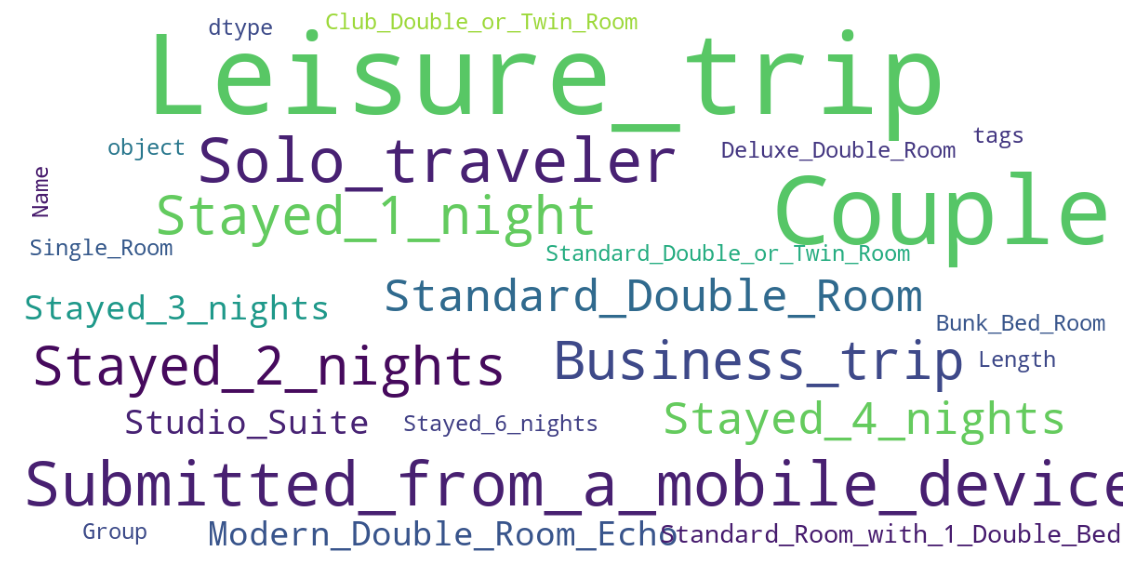

In [392]:
def get_tags_string(tags_data):
    tags_data = tags_data.replace('[', '').replace(']', '').replace("'", '')
    tags_list = tags_data.split(',')

    tags_string = ''
    for teg in tags_list:
        teg = teg.strip().replace(' ', '_')
        tags_string = tags_string + teg + ' '

    return tags_string


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()


cloud = hotels['tags'].apply(get_tags_string)
show_wordcloud(cloud)

In [393]:
hotels['len_tags'] = hotels['tags'].apply(lambda x: len(x.split(',')))
print(f'Максимальное количество тегов в 1 строке данных: {hotels["len_tags"].max()}')

# проанализируем типы тегов:
hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].head()

Максимальное количество тегов в 1 строке данных: 6


698              [' With a pet ', ' Leisure trip ', ' Solo traveler ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
1276                       [' With a pet ', ' Leisure trip ', ' Group ', ' Superior Twin Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
1407         [' With a pet ', ' Leisure trip ', ' Family with young children ', ' Family Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
2102    [' With a pet ', ' Business trip ', ' Couple ', ' King Room with City View Top floors ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
2281                                  [' With a pet ', ' Leisure trip ', ' Group ', ' 2 rooms ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
Name: tags, dtype: object

В данных можно выделить 6 типов тегов:
- путешествие с домашними животными
- путешествие по работе / отдых
- путешествие в каком составе (один, пара, компания друзей, семья с маленькими / взрослыми детьми, группа)
- категория номера
- длительность поездки
- доступ осуществляется с мобильного устройства

***Выделим теги в отдельные характеристики и присвоим им числовой код (кроме категории номера):***

#### Новые признаки:
#### ДОСТУП С МОБИЛЬНОГО ('tag_from_mobile')
#### ПУТЕШЕСТВИЕ С ЖИВОТНЫМИ ('tag_with_pet')
#### ПУТЕШЕСТВИЕ ПО РАБОТЕ ('tag_business_trip')
#### ОТДЫХ ('tag_leisure_trip')
#### КАТЕГОРИЯ ПУТЕШЕСТВЕННИКА ПО СОСТАВУ ('tag_reviewer_type')
#### КОЛИЧЕСТВО НОЧЕЙ В ОТЕЛЕ ('tag_count_nights')
#### ТИП НОМЕРА ('tag_room_type')

In [394]:
def get_tags(tags_string):
    tags_string = tags_string.replace('[', '').replace(']', '').replace("' ", '').replace(" '", '')
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    reviewer_types = {'Solo traveler': 1,
                      'Couple': 2,
                      'Travelers with friends': 3,
                      'Family with young children': 4,
                      'Family with older children': 5,
                      'Group': 6}

    tag_from_mobile = 0
    tag_with_pet = 0
    tag_business_trip = 0
    tag_leisure_trip = 0
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_room_type = ''

    for teg in list(tags_list):
        if teg == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(teg)
            continue

        if teg == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(teg)
            continue

        if teg == 'Business trip':
            tag_business_trip = 1
            tags_list.remove(teg)
            continue

        if teg == 'Leisure trip':
            tag_leisure_trip = 1
            tags_list.remove(teg)
            continue

        if teg in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[teg]
            tags_list.remove(teg)
            continue

        if re.fullmatch(r'Stayed\s\d+\snight\w?', teg):
            tag_count_nights = nums_from_string.get_nums(teg)[0]
            tags_list.remove(teg)
            continue

    if len(tags_list) > 0:
        tag_room_type = tags_list[0]

    return tag_from_mobile, tag_with_pet, tag_business_trip, tag_leisure_trip, tag_reviewer_type, tag_count_nights, tag_room_type

In [395]:
hotels[['tag_from_mobile', 'tag_with_pet', 'tag_business_trip', 'tag_leisure_trip', 'tag_reviewer_type', 'tag_count_nights', 'tag_room_type']] = \
    pd.DataFrame(hotels['tags'].apply(get_tags).tolist(), index=hotels.index)

#### <span style="color:green">Визуализируем таблицу распределения целевой переменной в разрезе количества проведенных в отеле дней:</span>

,count,mean
,reviewer_score,reviewer_score
tag_count_nights,,
0,146,6.485
1,145373,8.407
2,100263,8.387
3,72000,8.433
4,35748,8.408
5,15611,8.342
6,7399,8.320
7,5549,8.303


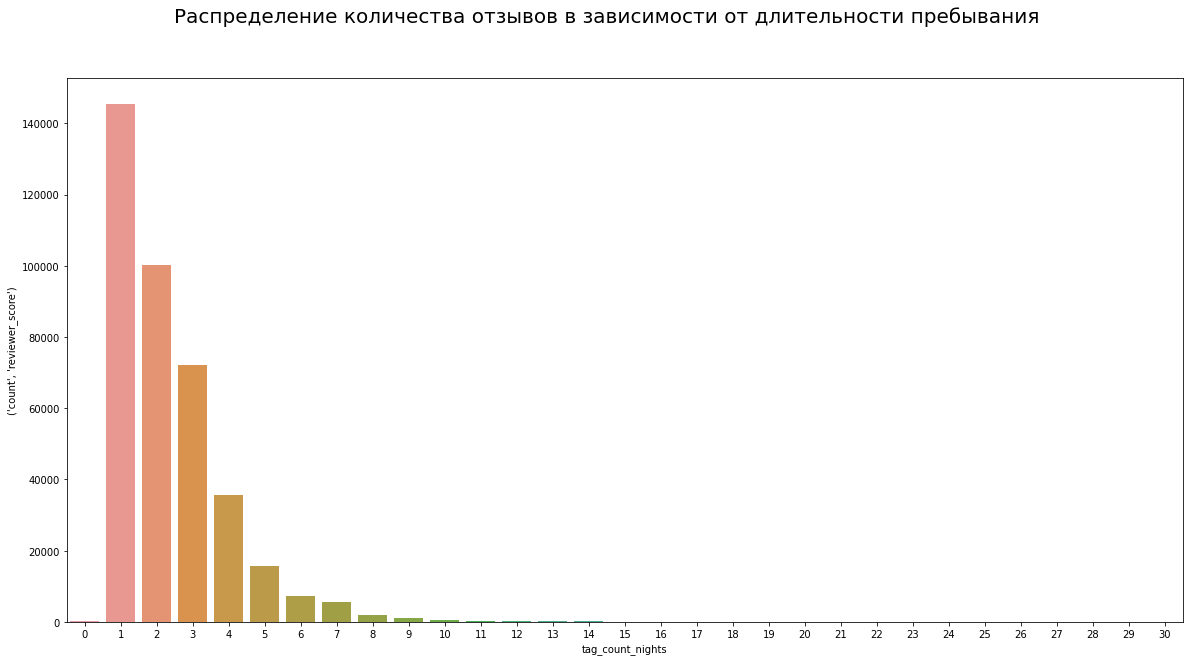

In [396]:
pivot_nights = pd.pivot_table(hotels,
                           index='tag_count_nights',
                           values='reviewer_score',
                           aggfunc=['count', 'mean'])

#pivot_adr = pivot_adr.reindex(pivot_adr['average_score'].sort_values(ascending=False).index)
display(pivot_nights)

# строим диаграмму:
fig3, ax3 = plt.subplots(figsize=(20, 10))
plt.suptitle('Распределение количества отзывов в зависимости от длительности пребывания', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')]);

***Наибольшие группы - это туристы, совершавшие короткие поездки длительностью 1-3 ночи. Логично, для городских отелей. С возрастанием длительности пребывания - количество отзывов постепенно снижается, а после показателя в 14 ночей (стандартная длина отпуска) - их количество падает резко.***

Странно, что у некоторых данных отсутствует информация о длительности пребывания в отеле. Вообще сайт тщательно проверяет отзывы на реальность.

In [397]:
hotels[hotels['tag_count_nights'] == 0][['positive_review', 'negative_review', 'tags']].head()

,positive_review,negative_review,tags
1865,Location 5 min by step from centre Duomo,Terrible mattresses my wife could not sleep all the night Noise from hotel ventillation system Poor breakfast Booking policy non refundable for the whole period,"[' Leisure trip ', ' Family with young children ']"
2320,No Positive,I didnt like the front desk manager he tries to be polite but he does not like to help at all Also i did not like the bathrooms and the bathtubs that are extremely small although the size of the bathroom is acceptable Also u did not like the bidet which is very difficult to use Also the noise of the tram whichbis running all night is very annoying,"[' Leisure trip ', ' Family with young children ', ' Submitted from a mobile device ']"
10014,Convenient to public transport,The bathroom is small and shower cubicle is even smaller,"[' Leisure trip ', ' Family with young children ', ' Submitted from a mobile device ']"
17474,All staff helpful friendly and made you feel special Thank you,Net curtains in room 231 were dusty Sorry but they made me sneeze,"[' Leisure trip ', ' Group ', ' Submitted from a mobile device ']"
25450,Nothing much,Room quite small for a family the bed was not comfy and a humming noise all night kept us awake The children had a sofa bed It was expensive for what we had,"[' Business trip ', ' Family with young children ']"


Может быть это поездки, задним числом аннулированные отелем с возвратом денег туристу, например, а отзыв о пребывании уже был опубликован.
Получается, что это самые настоящие аномалии в данных - заменим их средним значением столбца:

In [398]:
"""
mean_count_nights = round(hotels['tag_count_nights'].mean())
hotels['tag_count_nights'] = hotels['tag_count_nights'].apply(lambda x: mean_count_nights if x == 0 else x)
"""

"\nmean_count_nights = round(hotels['tag_count_nights'].mean())\nhotels['tag_count_nights'] = hotels['tag_count_nights'].apply(lambda x: mean_count_nights if x == 0 else x)\n"

***Рассмотрим внимательно категории номеров. Возможно получится выделить их в группы. Кажется, что отзывы о пребывании туристов, которые останавливаются в большом клубном номере с видом и маленьком экономе могут сильно отличаться.***

In [399]:
hotels['tag_room_type'].value_counts()

Double Room                           26386
Standard Double Room                  24151
Superior Double Room                  23550
Deluxe Double Room                    18623
Double or Twin Room                   16824
                                      ...  
Suite with Executive Lounge Access        1
Suite Free Executive Lounge Access        1
Suite Designer                            1
Duplex King Suite 3 Adults                1
Executive Double Room Non Smoking         1
Name: tag_room_type, Length: 2329, dtype: int64

#### Новый признак: НОМЕР С ВИДОМ ('tag_view_room')

In [400]:
hotels['tag_view_room'] = hotels['tag_room_type'].apply(lambda x: 1 if ('View' in x) | ('Panoramic' in x) else 0)

#### <span style="color:green">Визуализируем соотношение средних значений целевой переменной в разрезе полученного признака:</span>

In [401]:
# посмотрим, отличаются ли средние оценки отелей, в зависимости от этого показателя:
pivot_view = pd.pivot_table(hotels,
                           index=['tag_view_room'],
                           values='reviewer_score',
                           aggfunc=['mean', 'count'])
pivot_view

,mean,count
,reviewer_score,reviewer_score
tag_view_room,,
0,8.387,373590
1,8.667,13213


***Таких отзывов не очень много, но средний бал отзыва - отличается значительно!***

Попробуем разделить все номера на категории и посмотрим, отличается ли впечатление от отеля, в зависимости от категории номера:

In [402]:
# сформируем список основных категорий отельных номеров и присвоим соответствующее значение каждой группе:
def get_room_type(tag):
    room_types = ['without Window', 'Guestroom', 'Classic', 'Single', 'Standard',
                  'Superior', 'Comfort', 'Club', 'Suite', 'Deluxe', 'King', 'Premier']

    for rt in room_types:
        if rt in tag:
            return rt

    if 'Double' in tag or 'Twin' in tag:
        return 'Double'

    return 'Other'

hotels['room_type'] = hotels['tag_room_type'].apply(get_room_type)
hotels['room_type'].value_counts()

Double            95111
Superior          62958
Standard          59445
Deluxe            45314
Other             36855
Classic           27040
Single            19216
King              12042
Suite             11878
Club               6699
Comfort            5775
without Window     1865
Guestroom          1579
Premier            1026
Name: room_type, dtype: int64

#### <span style="color:green">Визуализируем соотношение средних значений целевой переменной в зависимости от категории номера:</span>

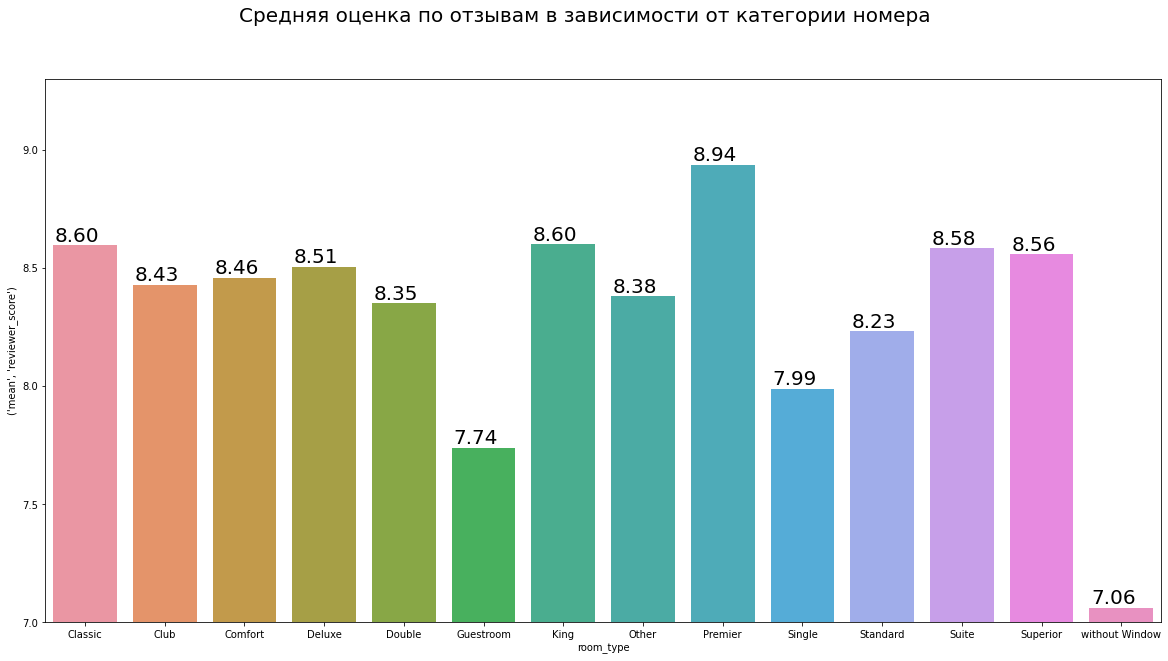

In [403]:
pivot_types = pd.pivot_table(hotels,
                           index='room_type',
                           values='reviewer_score',
                           aggfunc=['count', 'mean'])

# строим диаграмму:
fig4, ax4 = plt.subplots(figsize=(20, 10))
plt.suptitle('Средняя оценка по отзывам в зависимости от категории номера', size=20)
bar_types = sns.barplot(x=pivot_types.index, y=pivot_types[('mean', 'reviewer_score')])

for p in bar_types.patches:
    bar_types.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
    ha='center', va='bottom', fontsize=20)

plt.ylim(7, 9.3);

***Кодируем новые признаки:***

In [404]:
# ограничим количество категорий длительности пребывания:
hotels['nights_cat'] = hotels['tag_count_nights'].apply(lambda x: x if (x < 15)  else 15)

encoder_n = ce.OneHotEncoder(cols=['nights_cat'], use_cat_names=True)
nights_bin = encoder_n.fit_transform(hotels['nights_cat'])
hotels = pd.concat([hotels, nights_bin], axis=1)

encoder_t = ce.OneHotEncoder(cols=['tag_reviewer_type'], use_cat_names=True)
tag_type_bin = encoder_t.fit_transform(hotels['tag_reviewer_type'])
hotels = pd.concat([hotels, tag_type_bin], axis=1)

encoder_r = ce.OneHotEncoder(cols=['room_type'], use_cat_names=True)
tag_rooms_bin = encoder_r.fit_transform(hotels['room_type'])
hotels = pd.concat([hotels, tag_rooms_bin], axis=1)


# удалим ненужные столбцы:
hotels.drop(['tag_count_nights', 'nights_cat', 'tag_reviewer_type', 'room_type', 'tag_room_type'], axis=1, inplace=True)

* ### ОБЩЕЕ КОЛИЧЕСТВО ОТЗЫВОВ РЕЦЕНЗЕНТА ('total_number_of_reviews_reviewer_has_given')

Кажется, что такой параметр, как количество отзывов у рецензента - вообще не влияет на оценку отелю. Но возможно, конечно, что более "умудренные опытом" путешественники более требовательны и строги к объекту размещения. Или напротив, люди, которые много путешествуют - лучше знают чего хотят и имеют больше опыта в выборе объекта размещения. А значит, реже разочаровываются... Эти гипотезы нуждаются в проверке.

In [405]:
# Не удалять признак!!!
hotels['total_number_of_reviews_reviewer_has_given'].describe()

count   386803.000
mean         7.177
std         11.054
min          1.000
25%          1.000
50%          3.000
75%          8.000
max        355.000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

In [406]:
# Проведем корреляционные тест ANOVA:
_, p = stats.f_oneway(hotels['total_number_of_reviews_reviewer_has_given'], hotels['reviewer_score'])

if p > alpha:
  print(f"{p} > {alpha}. Нет статистически значимого влияния признака.")
else:
  print(f"{p} <= {alpha}. Есть статистически значимое влияние признака.")

0.0 <= 0.05. Есть статистически значимое влияние признака.


#### <span style="color:green">Визуализируем соотношение средних значений целевой переменной в зависимости от "активности" рецензента:</span>

In [407]:
hotels['reviewer_score']\
    .groupby(pd.cut(hotels['total_number_of_reviews_reviewer_has_given'], np.arange(0, 360, 25)))\
    .agg(['count', 'mean'])

,count,mean
total_number_of_reviews_reviewer_has_given,,
"(0, 25]",366215,8.396
"(25, 50]",16316,8.418
"(50, 75]",2953,8.409
"(75, 100]",864,8.316
"(100, 125]",218,8.503
"(125, 150]",107,8.293
"(150, 175]",87,8.685
"(175, 200]",16,9.225
"(200, 225]",11,7.855


Логарифмируем значение признака, чтобы оставить только информацию о степени (порядке) активности рецензента:

In [408]:
hotels['total_number_of_reviews_reviewer_has_given'] = hotels['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x+1))

## 1.3 ХАРКЕТИРСТИКИ ВРЕМЕНИ - ДАТЫ И ПЕРИОДЫ
***Дата размещения отзыва ('review_date')***
***Разница между датой отзыва и датой выгрузки данных ('days_since_review')***

* ### ДАТА РАЗМЕЩЕНИЯ ОТЗЫВА ('review_date')

In [409]:
# преобразуем данные в столбце в формат даты/времени:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_date'].sort_values()

143997   2015-08-04
86268    2015-08-04
159209   2015-08-04
217001   2015-08-04
28485    2015-08-04
            ...    
167325   2017-08-03
372341   2017-08-03
54669    2017-08-03
321881   2017-08-03
315137   2017-08-03
Name: review_date, Length: 386803, dtype: datetime64[ns]

У меня есть гипотеза, что на оценку туриста, параметр безусловно субъективный, часто влияет не только опыт пребывания в отеле, но и атмосфера путешествия в целом.
- Не секрет, что лучшим временем для путешествия в крупные европейские города многие считают период зимних новогодних и рождественских праздников. Улицы европейских мегаполисов превращаются в большие рождественские ярмарки и в отелям менеджмент часто создает непринужденную праздничную атмосферу. Кажется это силь должно влиять на общую оценку отелю.
- Весна также прекрасное время для посещения европейских городов. Уже довольно тепло для прогулок, но нет толп назойливых туристов.
- Летом, конечно, спорный период. Это пора отпусков и даже городские отели переполнены. Но долгожданное посещение Парижа или Милана может подпортить жара, например, проблемы с кондиционером, или очереди на завтраке. Персонал часто не справляется с большим потоком посетителей, отсюда, предполагаю что оценки посещения отеля летом будут одними из самых низких.
- Ну и осень. Осенью в Европейских отелях тоже не сладко :D. Начинаются холодные промозглые денечки, в номерах часто холодно и сыро. После летнего туристического сезона именно осенью многие отели устраивают ремонтные работы к рождественским каникулам, что может вызвать дополнительный дискомфорт постояльцев.

Мне кажется, что логичнее всего выделить в отдельные признаки - месяц, неделю и время года посещения отеля.

*PS. В последствии я отказалась от идеи сформировать время года в отдельный признак. И порядковое и категориальное кодирование сезона года ухудшало итоговый MAPE.*

#### Новые признаки:
#### НОМЕР НЕДЕЛИ ОТЗЫВА ('review_week')
#### НОМЕР МЕСЯЦА ОТЗЫВА ('review_month')

In [410]:
hotels['review_week'] = hotels['review_date'].apply(lambda x: x.isocalendar().week)
hotels['review_month'] = hotels['review_date'].dt.month

#### <span style="color:green">Визуализируем влияние месяца посещения отеля на средние настроения туристов:</span>

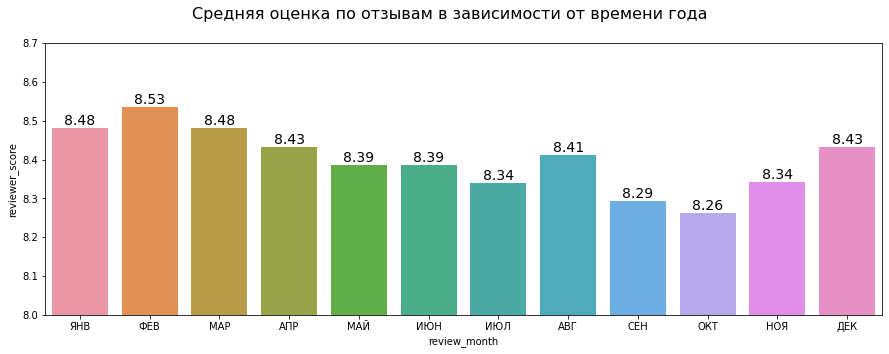

In [411]:
pivot_month = hotels[['review_month', 'reviewer_score']].groupby('review_month').mean()
fig5, ax5 = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от времени года', size=16)
bar_month = sns.barplot(x=pivot_month.index, y=pivot_month['reviewer_score'])
ax5.set_xticklabels(['ЯНВ', 'ФЕВ', 'МАР', 'АПР', 'MAЙ', 'ИЮН', 'ИЮЛ', 'АВГ', 'СЕН', 'ОКТ', 'НОЯ', 'ДЕК'])

for p in bar_month.patches:
    bar_month.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8, 8.7);

Визуализация предварительно подтверждает гипотетическую связь показателей.

***Кодируем Месяц:***

In [412]:
encoder_m = ce.OneHotEncoder(cols=['review_month'], use_cat_names=True)
month_bin = encoder_m.fit_transform(hotels['review_month'])
hotels = pd.concat([hotels, month_bin], axis=1)

# удалим ненужные столбцы:
hotels.drop('review_month', axis = 1, inplace=True)

* ### ВОЗРАСТ ОТЗЫВА В ДНЯХ ПРИ ВЫГРУЗКЕ ДАННЫХ ('days_since_review')

Вот этот признак, наконец-то, кажется ни с какой стороны не значим :D Удалим его, со спокойной совестью

In [413]:
hotels.drop('days_since_review', axis = 1, inplace=True)

## 1.4 Непосредственная информация об отзывах
***Отрицательный отзыв, который рецензент дал отелю ('negative_review')***
***Положительный отзыв, который рецензент дал отелю ('positive_review')***
***Общее количество слов в отрицательном отзыве ('review_total_negative_word_counts')***
***Общее количество слов в положительном отзыве ('review_total_positive_word_counts')***

Структура отзыва об отеле на сайте "Booking.com" устроена таким образом, что содержит в себе две части: Отрицательный отзыв и Положительный отзыв. После выставления оценок по категориям рецензенту предлагается ответить на два вопроса:
- Что вам не понравилось в объекте размещения?
- Что вам понравилось в объекте размещения?

Таким образом получается две части одного по сути ответа.

* ### КОЛИЧЕСТВО СЛОВ В ОТЗЫВЕ -
### НЕГАТИВНОМ (‘review_total_negative_word_counts’)
### ПОЗИТИВНОМ (‘review_total_positive_word_counts’)

Эти признаки уже напрямую дают нам информацию о том, удовлетворен ли турист пребыванием в отеле. В большинстве случаев, если все было прекрасно, на вопрос: Что вам не понравилось? - вы не ответите ничего или обойдетесь стандартной фразой типа "Все понравилось" или "Все было прекрасно!". Если же есть на что пожаловаться - эта часть отзыва будет длиннее. С положительной частью - то же самое. Проверим эту гипотезу:

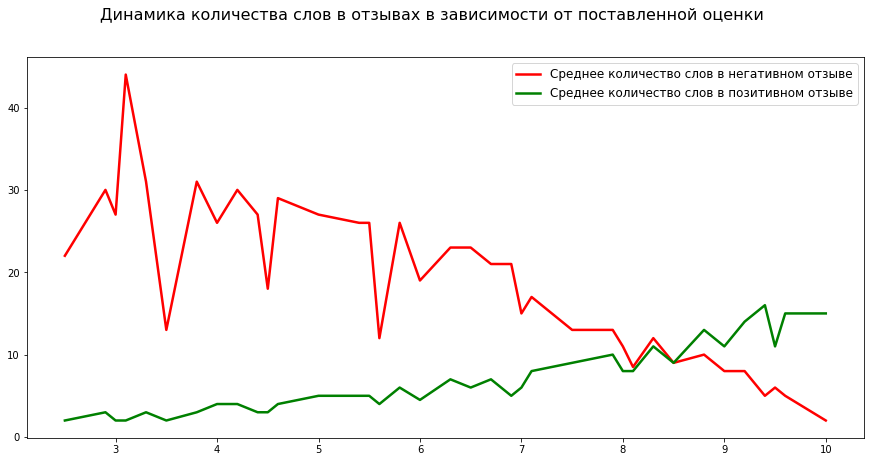

In [414]:
pivot_counts_words_neg = hotels[['reviewer_score', 'review_total_negative_word_counts']].groupby('reviewer_score').median()
pivot_counts_words_pos = hotels[['reviewer_score', 'review_total_positive_word_counts']].groupby('reviewer_score').median()

fig6, ax6 = plt.subplots(figsize=(15, 7))
plt.suptitle('Динамика количества слов в отзывах в зависимости от поставленной оценки', size=16)
line_count_neg = sns.lineplot(
    x=pivot_counts_words_neg.index,
    y=pivot_counts_words_neg['review_total_negative_word_counts'],
    color='red', linewidth=2.5
)
line_count_pos = sns.lineplot(
    x=pivot_counts_words_pos.index,
    y=pivot_counts_words_pos['review_total_positive_word_counts'],
    color='green', linewidth=2.5
)
ax6.set_xlabel('')
ax6.set_ylabel('')
ax6.legend(['Среднее количество слов в негативном отзыве', 'Среднее количество слов в позитивном отзыве'], loc='upper right', fontsize=12);

Очень наглядное подтверждение гипотезы о взаимосвязи количества слов в отзыве и оценки.
Также можно хорошо заметить, что люди больше склонны ругать за недостатки, чем хвалить за достоинства.

In [415]:
hotels[['review_total_negative_word_counts', 'review_total_positive_word_counts']].describe()

,review_total_negative_word_counts,review_total_positive_word_counts
count,386803.000,386803.000
mean,18.539,17.777
std,29.703,21.726
min,0.000,0.000
25%,2.000,5.000
50%,9.000,11.000
75%,23.000,22.000
max,408.000,395.000


#### Новые признаки:
####
#### ПОРЯДОК КОЛИЧЕСТВА СЛОВ В НЕГАТИВНОМ ОТЗЫВЕ ('review_total_negative_word_counts_log')
#### ПОРЯДОК КОЛИЧЕСТВА СЛОВ В ПОЗИТИВНОМ ОТЗЫВЕ ('review_total_positive_word_counts_log')
####
#### РАЗНИЦА КОЛИЧЕСТВА СЛОВ МЕЖДУ ЧАСТЯМИ ОТЗЫВОВ ('review_count_diff_word_counts')
#### ОТНОШЕНИЕ КОЛИЧЕСТВА СЛОВ МЕЖДУ ЧАСТЯМИ ОТЗЫВОВ ('review_coeff_diff_word_counts')
####
#### ДОЛЯ СЛОВ ПОЗИТИВНОГО ОТЗЫВА ВО ВСЕМ ОТЗЫВЕ ('review_portion_negative_word_counts')
#### ДОЛЯ СЛОВ НЕГАТИВНОГО ОТЗЫВА ВО ВСЕМ ОТЗЫВЕ ('review_portion_positive_word_counts')

Добавим количеству слов в отзыве порядковую характеристик, иными словами - логарифмируем данные. А также выделим в отдельные признаки разность и отношение данных величин:

In [416]:
hotels['review_total_negative_word_counts_log'] = hotels['review_total_negative_word_counts'].apply(lambda x: np.log(x+1))
hotels['review_total_positive_word_counts_log'] = hotels['review_total_positive_word_counts'].apply(lambda x: np.log(x+1))

In [417]:
hotels['review_count_diff_word_counts'] = hotels.apply(lambda row: row['review_total_positive_word_counts'] - row['review_total_negative_word_counts'], axis=1)
hotels['review_coeff_diff_word_counts'] = hotels.apply(lambda row: (row['review_total_positive_word_counts']+1) / (row['review_total_negative_word_counts']+1), axis=1)

* ### ТЕКСТ ОТЗЫВА -
### НЕГАТИВНЫЙ (‘negative_review’)
### ПОЗИТИВНЫЙ (‘positive_review’)

А теперь - самое интересное! Огромное количество информации для лучшего предсказания итоговой оценки содержится именно в этих столбцах!
Но для того чтобы параметрически оценить эти данны - нужен будет лингвистический анализ текста. Я попробую три подхода:
1) с использованием SentimentIntensityAnalyzer библиотеки nltk
2)

#### <span style="color:blue">Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки nltk:</span>

#### Новые признаки:
#### ОТРИЦАТЕЛЬНОЕ НАСТРОЕНИЕ В ОТЗЫВЕ (КОЭФФИЦИЕНТ) ('sentiments_neg')
#### НЕЙТРАЛЬНОЕ НАСТРОЕНИЕ В ОТЗЫВЕ (КОЭФФИЦИЕНТ) ('sentiments_neu')
#### ПОЛОЖИТЕЛЬНОЕ НАСТРОЕНИЕ В ОТЗЫВЕ (КОЭФФИЦИЕНТ) ('sentiments_pos')
#### СОВОКУПНОЕ НАСТРОЕНИЕ В ОТЗЫВЕ (КОЭФФИЦИЕНТ) ('sentiments_compound')

SentimentIntensityAnalyzer работает с необработанным текстом.

In [418]:
# соединим обе части отзыва в один блок и удалим метки отсутствия отзыва 'No Negative' / 'No Positive':
hotels['review'] = hotels['negative_review'] + hotels['positive_review']
hotels['review'] = hotels['review'].apply(lambda x: x.replace('No Negative', '').replace('No Positive', ''))

In [419]:
%%time

sia = SentimentIntensityAnalyzer()
hotels['sentiments'] = hotels['review'].apply(lambda x: sia.polarity_scores(x))

hotels[['review', 'reviewer_score', 'sentiments']]

CPU times: user 2min 32s, sys: 1.31 s, total: 2min 33s
Wall time: 2min 35s


,review,reviewer_score,sentiments
0,Leaving Staff were amazing,10.000,"{'neg': 0.0, 'neu': 0.441, 'pos': 0.559, 'compound': 0.5859}"
1,poor breakfast location,6.300,"{'neg': 0.608, 'neu': 0.392, 'pos': 0.0, 'compound': -0.4767}"
2,No kettle in room,7.500,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'compound': -0.296}"
3,Friendly staff quiet comfortable room spotlessly clean excellent location,10.000,"{'neg': 0.0, 'neu': 0.279, 'pos': 0.721, 'compound': 0.9169}"
4,Torn sheets The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,9.600,"{'neg': 0.073, 'neu': 0.587, 'pos': 0.34, 'compound': 0.8051}"
...,...,...,...
386798,Tr s proche du metro Earl s court,8.800,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
386799,The bed was so comfy I stayed with my boyfriend we had a double bed Also transportation is excellent the hotel is very very close to Old City Once you exit the hotel just turn right about 50m away there is a bus stop get off on Stubentor it is the last stop It only takes 10min Also you can take the same bus back to the hotel The bus name is 74A St Marx The hotel was very clean and the room that we accomidated in was nice and roomy,9.200,"{'neg': 0.045, 'neu': 0.857, 'pos': 0.098, 'compound': 0.7264}"
386800,room is really small but guess is normal in London great location simple check in out nice shower,8.300,"{'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'compound': 0.8847}"
386801,Location and very comfy bed,9.200,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


In [420]:
hotels['sentiments_neg'] = hotels['sentiments'].apply(lambda x: x['neg'])
hotels['sentiments_neu'] = hotels['sentiments'].apply(lambda x: x['neu'])
hotels['sentiments_pos'] = hotels['sentiments'].apply(lambda x: x['pos'])
hotels['sentiments_compound'] = hotels['sentiments'].apply(lambda x: x['compound'])


#### <span style="color:blue">Анализ настроений с помощью TextBlob:</span>

In [421]:
%%time

def get_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment_assessments.polarity


hotels['negative_polarity'] = hotels['negative_review'].apply(get_polarity)
hotels['positive_polarity'] = hotels['positive_review'].apply(get_polarity)

CPU times: user 4min 17s, sys: 1.57 s, total: 4min 19s
Wall time: 4min 23s


In [422]:
%%time

tb = textblob.Blobber(analyzer=NaiveBayesAnalyzer())
for index, row_h in hotels.iterrows():
    sent_neg = tb(row_h['negative_review']).sentiment
    hotels.loc[index, 'negative_review_class'] = sent_neg[0]
    hotels.loc[index, 'negative_review_pos'] = sent_neg[1]
    hotels.loc[index, 'negative_review_neg'] = sent_neg[2]

    sent_pos = tb(row_h['positive_review']).sentiment
    hotels.loc[index, 'positive_review_class'] = sent_pos[0]
    hotels.loc[index, 'positive_review_pos'] = sent_pos[1]
    hotels.loc[index, 'positive_review_neg'] = sent_pos[2]

hotels['positive_review_class'] = hotels['positive_review_class'].apply(lambda x: 1 if x == 'pos' else 0)
hotels['negative_review_class'] = hotels['negative_review_class'].apply(lambda x: 1 if x == 'pos' else 0)

# мы получили 6 новых параметров
# теперь на основе классификации обеих частей отзыва - создадим новый признак итоговой классификации:
def get_reviewer_classification(positive_review_class, negative_review_class):
    if positive_review_class + negative_review_class == 2:
        return 10.0
    if positive_review_class == 1 and negative_review_class == 0:
        return 7.5
    if positive_review_class == 0 and negative_review_class == 1:
        return 5.0
    return 2.5

hotels['reviewer_classification'] = hotels.apply(lambda row: get_reviewer_classification(row['positive_review_class'], row['negative_review_class']), axis=1)

CPU times: user 7min 32s, sys: 3.25 s, total: 7min 35s
Wall time: 7min 40s


In [423]:
hotels['mean_pos_coeff'] = hotels.apply(lambda row: row['positive_polarity'] + row['positive_review_pos'] + row['sentiments_pos'], axis=1)
hotels['mean_neg_coeff'] = hotels.apply(lambda row: row['negative_polarity'] + row['negative_review_neg'] + row['sentiments_neg'], axis=1)

# 2. Анализ признаков:

In [424]:
col_for_drop = [
    'total_number_of_reviews',
    'additional_number_of_scoring',
    'lat',
    'lng'
]

# Удаление координат улучшает MAPE на 0.004

hotels.drop(col_for_drop, axis = 1, inplace=True)

# 3. Обучение модели и получение предсказания:

In [425]:
# !!! УДАЛИТЬ !!!

object_columns = [s for s in hotels.columns
                  if ((hotels[s].dtypes == 'object') | (hotels[s].dtypes == 'category') | (hotels[s].dtypes == 'datetime64[ns]'))]
# hotels.drop(object_columns, axis = 1, inplace=True)

hotels.drop(object_columns, axis = 1, inplace=True)

hotels = hotels.fillna(0)



In [426]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 0 to 386802
Data columns (total 86 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386803 non-null  float64
 1   review_total_negative_word_counts           386803 non-null  int64  
 2   review_total_positive_word_counts           386803 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  386803 non-null  float64
 4   reviewer_score                              386803 non-null  float64
 5   hotel_code                                  386803 non-null  int64  
 6   hotel_country_code                          386803 non-null  int8   
 7   district_code                               386803 non-null  int64  
 8   district_rating                             386803 non-null  float64
 9   hotel_distance_to_center                    386803 non-null  float64
 

In [427]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X_df = hotels.drop(['reviewer_score'], axis = 1)
y = hotels['reviewer_score']


In [428]:

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.25, random_state=42)


In [429]:
%%time

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)


CPU times: user 12min 2s, sys: 3.91 s, total: 12min 6s
Wall time: 12min 16s


In [430]:

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))


MAPE: 0.12165755947071726
